In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [2]:
# Display setting for dataframe in notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
decimal = 5
pd.set_option('display.float_format', lambda x: f'%.{decimal}f' % x)

# Import Data

In [3]:
# df_FS = pd.read_pickle("./data_pickle/data_FS.pkl")

In [4]:
df_FS = pd.read_pickle("./data_pickle/data_FS_v1.pkl")

In [5]:
#Check number of 0 value
def miss_checker(data: pd.DataFrame, fig_size=(15,10)):
    nobs = data.shape[0]
    feature = data.columns
    abs_missing = (data==0).sum().to_list()
    ratio_missing = 100*((data==0).sum()/ nobs)
    tab = pd.DataFrame({'Column': feature, 
                        'Abs_missing': abs_missing,
                        'Percent_missing': ratio_missing})
#     tab.sort_values('Abs_missing', inplace=True)
#     tab.plot.barh(x='Column', y='Percent_missing', rot = 0, figsize=fig_size)
    
    return tab

In [6]:
miss_checker(df_FS)

,Column,Abs_missing,Percent_missing
Ticker,Ticker,0,0.00000
ComGroupCode,ComGroupCode,0,0.00000
en_OrganName,en_OrganName,0,0.00000
YearReport_t0,YearReport_t0,0,0.00000
YearReport_t1,YearReport_t1,0,0.00000
YearReport_t2,YearReport_t2,0,0.00000
CurrentAsset_t0,CurrentAsset_t0,0,0.00000
CurrentAsset_t1,CurrentAsset_t1,0,0.00000
CurrentAsset_t2,CurrentAsset_t2,0,0.00000
CashAndEquivalent_t0,CashAndEquivalent_t0,0,0.00000


In [7]:
def list_denominators(df_FS, config):
    denominators = set()
    pattern = re.compile(r"/\s*(\w+(?:\s*\+\s*\w+)*)")

    for formula in config['formula']:
        # Find all denominators in the formula
        matches = pattern.findall(formula)
        for match in matches:
            parts = [part.strip() for part in match.split('+')]
            for part in parts:
                if part in df_FS.columns:
                    denominators.add(part)
    
    return list(denominators)

In [8]:
def calculate_score(df_FS, config, col_denom):
    df_score = pd.DataFrame()
    df_score['Ticker'] = df_FS['Ticker']
    
    df_used = df_FS.copy()
    df_used[col_denom] = df_used[col_denom].fillna(0.00001)
    df_used[col_denom] = df_used[col_denom].replace(0, 0.00001)

    for index, row in config.iterrows():
        new_col = row['new_col']
        formula = row['formula']
        for old_col in df_used.columns:
            formula = formula.replace(old_col, f"df_used['{old_col}']")
        df_score[new_col] = eval(formula)
        
    return df_score

In [9]:
def winsorize(data, lower_pct, upper_pct):
    data = pd.to_numeric(data, errors='coerce')
    
    lower_limit = data.quantile(lower_pct)
    upper_limit = data.quantile(upper_pct)
    
    data[data < lower_limit] = lower_limit
    data[data > upper_limit] = upper_limit
    
    return data

# Calculate long list features

In [10]:
config = pd.read_excel("./data/config_longlist.xlsx")
config

,new_col,formula
0,OP/SAL,OperatingProfit_t0 / RevenueNet_t0
1,EBIT/TA,OperatingProfit_t0/ TotalAssets_t0
2,GP/FA,GrossProfit_t0 / PPE_t0
3,NI/CS,NetIncome_t0 / CostOfSales_t0
4,GP/SAL,GrossProfit_t0 / RevenueNet_t0
5,GP/TA,GrossProfit_t0 / TotalAssets_t0
6,NI/EQ,NetIncome_t0 / TotalEquity_t0
7,CS/GP,CostOfSales_t0 / GrossProfit_t0
8,GP/CS,GrossProfit_t0 / CostOfSales_t0
9,NI/TA,NetIncome_t0 / TotalAssets_t0


In [11]:
col_denom = list_denominators(df_FS, config)
col_denom

['TotalEquity_t0',
 'Liability_ST_t0',
 'CFO_t0',
 'CurrentAsset_t0',
 'CostOfSales_t1',
 'SGA_t1',
 'NetIncome_t0',
 'TotalLiability_t0',
 'GrossProfit_t0',
 'SGA_t0',
 'PPE_t0',
 'TotalAssets_t0',
 'CostOfSales_t0',
 'RevenueNet_t0']

In [12]:
#Manually adjust for better SAL/CS, SAL/COST, SAL/GA, add RevenueNet_t1 to col_denom
col_denom.append('RevenueNet_t1')
col_denom

['TotalEquity_t0',
 'Liability_ST_t0',
 'CFO_t0',
 'CurrentAsset_t0',
 'CostOfSales_t1',
 'SGA_t1',
 'NetIncome_t0',
 'TotalLiability_t0',
 'GrossProfit_t0',
 'SGA_t0',
 'PPE_t0',
 'TotalAssets_t0',
 'CostOfSales_t0',
 'RevenueNet_t0',
 'RevenueNet_t1']

In [13]:
df_score = calculate_score(df_FS, config, col_denom)
df_score.describe()

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-9677076507922.25977,0.04630,35083519032894.70312,-7966603102533.01953,0.21943,0.14603,0.06415,-9.66894,1029944767376.00098,0.03063,-9677076508530.45508,-0.26222,-8285599892956.85645,-0.02463,-136461620178271.64062,-136674404424295.54688,3.71268,0.05526,-17.23035,0.61182,0.08039,0.52323,0.15626,0.08294,2.91790,0.82063,3.09231,2.36626,0.19294,0.38820,NaN,2.44958,152072860158751.53125,1.04320,0.22776,-623084524157.78955,744167489025.91040,-12708317325773.59570,0.15942,0.25863,67725729331682.23438,308049907856327.12500
std,169148918521156.34375,0.10291,957776631155572.62500,261253637752135.87500,1.02246,0.15157,1.29557,37.41584,29054801931380.10547,0.13214,169148918521115.50000,4.14800,260980092666456.78125,0.16510,3811569890470113.50000,3811552136662018.50000,86.92867,0.14578,735.90276,1.51056,1.49805,2.20415,0.16810,0.10037,7.50676,0.24002,9.28476,6.25768,1.44080,1.51057,NaN,7.46818,3751749973094456.50000,1.18901,0.23144,25524193392163.79688,21007716709748.44531,755244125779942.12500,0.16261,0.22462,2367557043212026.00000,8630637278227711.00000
min,-4615272242600000.00000,-1.20765,-3129024688699999.50000,-7311309621799999.00000,-6.87261,-0.73137,-37.97985,-821.37250,-20.09666,-3.04894,-4615272242600000.00000,-117.19732,-7311309621799999.00000,-2.96422,-121622066955299984.00000,-121622066955299984.00000,-236.23378,-1.01049,-29161.72761,0.00694,-41.13358,0.00003,0.00007,0.00007,0.01325,0.02529,-0.97606,0.00849,-28.08396,-40.77334,-inf,0.00700,-250049179499999.96875,-0.02755,0.00000,-1019700486600000.00000,-8641349853639.74512,-29156800190619844.00000,0.00000,0.00000,-1329.89345,-146.44508
25%,0.00795,0.00563,0.26250,-0.14435,0.08095,0.04917,0.01654,-9.72406,-0.36884,0.00462,0.14502,0.00595,0.00631,-0.08145,-0.21271,-0.01409,-0.08818,-0.00910,-0.28838,0.29227,0.03010,0.04114,0.03341,0.01657,1.06849,0.72342,0.46060,0.79603,-0.01643,0.31535,0.79209,0.62866,1.91341,0.32884,0.04217,0.96315,0.96603,0.81004,0.02289,0.06287,-0.33442,0.11807
50%,0.04258,0.03899,0.84292,-0.04059,0.15088,0.11054,0.07268,-4.96345,-0.17324,0.03106,0.37941,0.04425,0.03395,-0.02181,-0.07314,0.06122,0.28882,0.04739,0.93395,0.49771,0.16491,0.15013,0.09810,0.04835,1.40792,0.94285,1.00921,1.19530,0.09803,0.50229,1.33244,1.04662,5.92364,0.75169,0.14725,1.00202,1.00027,0.97767,0.11280,0.21230,-0.14400,0.25795
75%,0.10643,0.08748,2.49489,-0.00699,0.27613,0.20347,0.14593,-2.20930,-0.08397,0.06984,0.64000,0.10108,0.10426,0.04135,0.01398,0.16436,0.81007,0.12825,2.72950,0.68465,0.36414,0.39581,0.21924,0.11090,2.38987,0.99834,2.42145,2.00062,0.32241,0.70773,2.36024,1.85193,17.71359,1.32593,0.34492,1.03347,1.02246,1.15781,0.25079,0.39733,-0.04060,0.60091
max,28.74770,1.22795,35030316291399996.00000,4015226668899999.50000,27.09917,1.34012,26.01000,342.74871,941936543299999.87500,1.27391,293.14618,0.78992,4015226668899999.50000,0.90961,350499582400000.00000,343621437300000.00000,2801.19110,0.96353,1493.83707,41.77334,0.98584,63.08885,0.98822,0.71821,159.70772,1.07788,143.14305,130.12082,21.77778,0.99306,inf,159.70772,144898214830400000.00000,16.52964,0.96814,23769400000000.00000,803222328496844.12500,7689359080824533.00000,0.91985,0.96465,94125502411000000.00000,321249812620099968.00000


In [14]:
#Manually adjust some ratios EQ/LA
df_score['Assets_LT_tmp'] = (df_FS['TotalAssets_t0'] - df_FS['CurrentAsset_t0']).replace(0, 0.00001)
df_score['EQ/LA'] = df_FS['TotalEquity_t0'] / df_score['Assets_LT_tmp']
df_score.drop(columns='Assets_LT_tmp', inplace=True)
df_score.describe()

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-9677076507922.25977,0.04630,35083519032894.70312,-7966603102533.01953,0.21943,0.14603,0.06415,-9.66894,1029944767376.00098,0.03063,-9677076508530.45508,-0.26222,-8285599892956.85645,-0.02463,-136461620178271.64062,-136674404424295.54688,3.71268,0.05526,-17.23035,0.61182,0.08039,0.52323,0.15626,0.08294,2.91790,0.82063,3.09231,2.36626,0.19294,0.38820,443884771632.08710,2.44958,152072860158751.53125,1.04320,0.22776,-623084524157.78955,744167489025.91040,-12708317325773.59570,0.15942,0.25863,67725729331682.23438,308049907856327.12500
std,169148918521156.34375,0.10291,957776631155572.62500,261253637752135.87500,1.02246,0.15157,1.29557,37.41584,29054801931380.10547,0.13214,169148918521115.50000,4.14800,260980092666456.78125,0.16510,3811569890470113.50000,3811552136662018.50000,86.92867,0.14578,735.90276,1.51056,1.49805,2.20415,0.16810,0.10037,7.50676,0.24002,9.28476,6.25768,1.44080,1.51057,19807489456049.08984,7.46818,3751749973094456.50000,1.18901,0.23144,25524193392163.79688,21007716709748.44531,755244125779942.12500,0.16261,0.22462,2367557043212026.00000,8630637278227711.00000
min,-4615272242600000.00000,-1.20765,-3129024688699999.50000,-7311309621799999.00000,-6.87261,-0.73137,-37.97985,-821.37250,-20.09666,-3.04894,-4615272242600000.00000,-117.19732,-7311309621799999.00000,-2.96422,-121622066955299984.00000,-121622066955299984.00000,-236.23378,-1.01049,-29161.72761,0.00694,-41.13358,0.00003,0.00007,0.00007,0.01325,0.02529,-0.97606,0.00849,-28.08396,-40.77334,-78700994300000.00000,0.00700,-250049179499999.96875,-0.02755,0.00000,-1019700486600000.00000,-8641349853639.74512,-29156800190619844.00000,0.00000,0.00000,-1329.89345,-146.44508
25%,0.00795,0.00563,0.26250,-0.14435,0.08095,0.04917,0.01654,-9.72406,-0.36884,0.00462,0.14502,0.00595,0.00631,-0.08145,-0.21271,-0.01409,-0.08818,-0.00910,-0.28838,0.29227,0.03010,0.04114,0.03341,0.01657,1.06849,0.72342,0.46060,0.79603,-0.01643,0.31535,0.79209,0.62866,1.91341,0.32884,0.04217,0.96315,0.96603,0.81004,0.02289,0.06287,-0.33442,0.11807
50%,0.04258,0.03899,0.84292,-0.04059,0.15088,0.11054,0.07268,-4.96345,-0.17324,0.03106,0.37941,0.04425,0.03395,-0.02181,-0.07314,0.06122,0.28882,0.04739,0.93395,0.49771,0.16491,0.15013,0.09810,0.04835,1.40792,0.94285,1.00921,1.19530,0.09803,0.50229,1.33244,1.04662,5.92364,0.75169,0.14725,1.00202,1.00027,0.97767,0.11280,0.21230,-0.14400,0.25795
75%,0.10643,0.08748,2.49489,-0.00699,0.27613,0.20347,0.14593,-2.20930,-0.08397,0.06984,0.64000,0.10108,0.10426,0.04135,0.01398,0.16436,0.81007,0.12825,2.72950,0.68465,0.36414,0.39581,0.21924,0.11090,2.38987,0.99834,2.42145,2.00062,0.32241,0.70773,2.36024,1.85193,17.71359,1.32593,0.34492,1.03347,1.02246,1.15781,0.25079,0.39733,-0.04060,0.60091
max,28.74770,1.22795,35030316291399996.00000,4015226668899999.50000,27.09917,1.34012,26.01000,342.74871,941936543299999.87500,1.27391,293.14618,0.78992,4015226668899999.50000,0.90961,350499582400000.00000,343621437300000.00000,2801.19110,0.96353,1493.83707,41.77334,0.98584,63.08885,0.98822,0.71821,159.70772,1.07788,143.14305,130.12082,21.77778,0.99306,787584974099999.87500,159.70772,144898214830400000.00000,16.52964,0.96814,23769400000000.00000,803222328496844.12500,7689359080824533.00000,0.91985,0.96465,94125502411000000.00000,

In [15]:
data = pd.read_excel("./data/features_list.xlsx", sheet_name=['Mscore', 'Fscore', 'Zscore'])
df_Mscore = data['Mscore']
df_Fscore = data['Fscore']
df_Zscore = data['Zscore']

In [16]:
df_score = pd.merge(df_score, df_Mscore.iloc[:, :-1], on='Ticker', how='inner')
df_score = pd.merge(df_score, df_Fscore.iloc[:, :-2], on='Ticker', how='inner')
df_score

,Ticker,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
0,A32,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0
1,AAA,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0
2,AAM,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-821.37250,-0.00122,-0.05677,-108.18156,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0
3,AAS,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0
4,AAT,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-643.63802,0.02634,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,36.96762,14.08794,-5.15770,0.97366,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0
1593,YBC,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0.97358,0.45444,1.00376,1.00114,0.91185,0.24974,0.52419,-0.27641,0.22600,0.83668,0.74727,1.12244,0.06558,1.00181,0.97785,1.09667,1.03548,-0.00718,-0.04690,0.02122,0.53618,1.05866,-0.00051,0
1594,YBM,0.09132,0.09270,0.68948,-0.04516,0.30899,0.31365,0.07732,-2.23635,-0.44716,0.03

In [17]:
df_score.describe()

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-9677076507922.25977,0.04630,35083519032894.70312,-7966603102533.01953,0.21943,0.14603,0.06415,-9.66894,1029944767376.00098,0.03063,-9677076508530.45508,-0.26222,-8285599892956.85645,-0.02463,-136461620178271.64062,-136674404424295.54688,3.71268,0.05526,-17.23035,0.61182,0.08039,0.52323,0.15626,0.08294,2.91790,0.82063,3.09231,2.36626,0.19294,0.38820,443884771632.08710,2.44958,152072860158751.53125,1.04320,0.22776,-623084524157.78955,744167489025.91040,-12708317325773.59570,0.15942,0.25863,67725729331682.23438,308049907856327.12500,1.21248,1.55704,1.17035,-0.01013,0.99518,1.07800,1.11100,1.05022,-0.03597,-0.01335,-0.01594,0.68931,66218379744663.59375,-0.00562,0.00564
std,169148918521156.34375,0.10291,957776631155572.62500,261253637752135.87500,1.02246,0.15157,1.29557,37.41584,29054801931380.10547,0.13214,169148918521115.50000,4.14800,260980092666456.78125,0.16510,3811569890470113.50000,3811552136662018.50000,86.92867,0.14578,735.90276,1.51056,1.49805,2.20415,0.16810,0.10037,7.50676,0.24002,9.28476,6.25768,1.44080,1.51057,19807489456049.08984,7.46818,3751749973094456.50000,1.18901,0.23144,25524193392163.79688,21007716709748.44531,755244125779942.12500,0.16261,0.22462,2367557043212026.00000,8630637278227711.00000,1.02667,2.36445,0.83628,0.12517,0.07454,0.60643,0.68228,0.33110,0.21223,0.14506,0.09960,0.24021,2647319679617330.50000,0.14119,0.07488
min,-4615272242600000.00000,-1.20765,-3129024688699999.50000,-7311309621799999.00000,-6.87261,-0.73137,-37.97985,-821.37250,-20.09666,-3.04894,-4615272242600000.00000,-117.19732,-7311309621799999.00000,-2.96422,-121622066955299984.00000,-121622066955299984.00000,-236.23378,-1.01049,-29161.72761,0.00694,-41.13358,0.00003,0.00007,0.00007,0.01325,0.02529,-0.97606,0.00849,-28.08396,-40.77334,-78700994300000.00000,0.00700,-250049179499999.96875,-0.02755,0.00000,-1019700486600000.00000,-8641349853639.74512,-29156800190619844.00000,0.00000,0.00000,-1329.89345,-146.44508,0.00715,0.04138,0.00000,-0.43771,0.59849,0.05629,-0.92528,0.26549,-3.18683,-1.06007,-0.80160,0.00732,-50355067918692.32812,-3.68183,0.00000
25%,0.00795,0.00563,0.26250,-0.14435,0.08095,0.04917,0.01654,-9.72406,-0.36884,0.00462,0.14502,0.00595,0.00631,-0.08145,-0.21271,-0.01409,-0.08818,-0.00910,-0.28838,0.29227,0.03010,0.04114,0.03341,0.01657,1.06849,0.72342,0.46060,0.79603,-0.01643,0.31535,0.79209,0.62866,1.91341,0.32884,0.04217,0.96315,0.96603,0.81004,0.02289,0.06287,-0.33442,0.11807,0.72894,0.86893,0.97902,-0.06490,0.98372,0.80058,0.84910,0.91508,-0.07385,-0.04565,-0.03561,0.54258,0.88192,-0.01995,0.00000
50%,0.04258,0.03899,0.84292,-0.04059,0.15088,0.11054,0.07268,-4.96345,-0.17324,0.03106,0.37941,0.04425,0.03395,-0.02181,-0.07314,0.06122,0.28882,0.04739,0.93395,0.49771,0.16491,0.15013,0.09810,0.04835,1.40792,0.94285,1.00921,1.19530,0.09803,0.50229,1.33244,1.04662,5.92364,0.75169,0.14725,1.00202,1.00027,0.97767,0.11280,0.21230,-0.14400,0.25795,0.98646,1.03483,1.03063,-0.00955,1.00090,0.96136,1.01643,1.01259,-0.01594,-0.00376,-0.00084,0.7

In [18]:
for col in df_score.columns[1:-1]:
    df_score[col] = winsorize(df_score[col], 0.01, 0.98)
df_score.describe()

,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-0.12555,0.04562,5.99177,-0.16718,0.19156,0.14464,0.07219,-8.74484,-0.31954,0.03285,-0.58190,-0.05902,-0.21130,-0.02357,-0.17304,-0.03565,0.27702,0.05477,0.16793,0.50910,0.15646,0.38370,0.15414,0.08100,2.43148,0.82094,2.47506,1.92870,0.17998,0.47103,2.27657,1.96147,49.44864,1.00377,0.22660,0.98848,0.98890,1.06234,0.15760,0.25721,-0.51276,1.09759,1.21223,1.55507,1.16998,-0.01012,0.99517,1.07790,1.11098,1.05004,-0.03754,-0.01417,-0.01768,0.68948,0.91337,-0.00668,0.00564
std,1.52530,0.07665,21.61166,0.76289,0.20228,0.13395,0.15443,15.17564,0.49542,0.07691,7.35586,0.57038,2.09994,0.12829,1.16625,0.80221,3.92637,0.13008,18.61369,0.29299,0.39720,0.65244,0.16049,0.09204,3.00558,0.23886,4.16310,2.40281,0.56891,0.38854,3.70012,2.86391,192.13764,0.96033,0.22815,0.17954,0.18976,0.59128,0.15672,0.22083,1.61753,3.18530,1.02544,2.35273,0.83405,0.12514,0.07449,0.60600,0.68208,0.33036,0.15194,0.12286,0.08187,0.23952,1.25308,0.06222,0.07488
min,-13.45187,-0.22438,-1.74947,-5.68411,-0.61776,-0.08372,-0.68776,-108.67831,-3.00427,-0.29831,-66.76214,-4.33844,-19.31641,-0.47398,-8.97960,-6.32413,-20.99855,-0.35388,-136.24015,0.02639,-2.43502,0.00080,0.00092,0.00067,0.09833,0.11078,-0.66567,0.04792,-2.20922,-1.99322,-6.76710,0.04699,0.01859,0.00028,0.00000,0.07909,0.09371,-0.12404,0.00000,0.00000,-13.01786,0.00969,0.00724,0.04147,0.00000,-0.43714,0.59868,0.05634,-0.92389,0.26550,-0.73998,-0.50305,-0.38334,0.06785,-6.00245,-0.29035,0.00000
25%,0.00795,0.00563,0.26250,-0.14435,0.08095,0.04917,0.01654,-9.72406,-0.36884,0.00462,0.14502,0.00595,0.00631,-0.08145,-0.21271,-0.01409,-0.08818,-0.00910,-0.28838,0.29227,0.03010,0.04114,0.03341,0.01657,1.06849,0.72342,0.46060,0.79603,-0.01643,0.31535,0.79209,0.62866,1.91341,0.32884,0.04217,0.96315,0.96603,0.81004,0.02289,0.06287,-0.33442,0.11807,0.72894,0.86893,0.97902,-0.06490,0.98372,0.80058,0.84910,0.91508,-0.07385,-0.04565,-0.03561,0.54258,0.88192,-0.01995,0.00000
50%,0.04258,0.03899,0.84292,-0.04059,0.15088,0.11054,0.07268,-4.96345,-0.17324,0.03106,0.37941,0.04425,0.03395,-0.02181,-0.07314,0.06122,0.28882,0.04739,0.93395,0.49771,0.16491,0.15013,0.09810,0.04835,1.40792,0.94285,1.00921,1.19530,0.09803,0.50229,1.33244,1.04662,5.92364,0.75169,0.14725,1.00202,1.00027,0.97767,0.11280,0.21230,-0.14400,0.25795,0.98646,1.03483,1.03063,-0.00955,1.00090,0.96136,1.01643,1.01259,-0.01594,-0.00376,-0.00084,0.74630,0.99468,-0.00123,0.00000
75%,0.10643,0.08748,2.49489,-0.00699,0.27613,0.20347,0.14593,-2.20930,-0.08397,0.06984,0.64000,0.10108,0.10426,0.04135,0.01398,0.16436,0.81007,0.12825,2.72950,0.68465,0.36414,0.39581,0.21924,0.11090,2.38987,0.99834,2.42145,2.00062,0.32241,0.70773,2.36024,1.85193,17.71359,1.32593,0.34492,1.03347,1.02246,1.15781,0.25079,0.39733,-0.04060,0.60091,1.30795,1.31552,1.14647,0.04521,1.01476,1.16753,1.21146,1.11883,0.02148,0.03203,0.00747,0.88421,1.05376,0.01331,0.00000
max,0.78185,0.24000,141.74847,1.31916,0.75517,0.57146,0.43523,8.77654,0.41775,0.20728,3.08952,0.34866,0.69002,0.29994,2.72035,0.95721,14.086

In [19]:
df_with_score = pd.merge(df_Mscore.iloc[:, [0, -1]], df_Fscore.iloc[:, [0, -1]], on='Ticker', how='inner')
df_with_score = pd.merge(df_with_score, df_Zscore.iloc[:, [0, -1]], on='Ticker', how='inner')
df_with_score = pd.merge(df_with_score, df_score, on='Ticker', how='inner')
df_with_score

,Ticker,mscore,fscore,zscore,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
0,A32,-2.79397,0.49848,6.76237,0.05785,0.08632,0.66586,-0.06488,0.10925,0.16301,0.17384,-8.15347,-0.12265,0.08623,0.52955,0.12661,0.05779,0.07747,-0.00659,0.00587,9.83866,0.00876,0.10164,0.50395,0.22653,0.18026,0.12436,0.09084,1.44950,1.00000,0.98431,1.44950,0.01739,0.49605,1.84050,0.67556,6.09490,1.49209,0.24481,0.99933,1.00778,1.15423,0.39003,0.53394,-0.29346,0.16720,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0
1,AAA,-3.86643,0.37259,5.22722,0.04767,0.04132,0.34603,-0.04257,0.10459,0.09066,0.07037,-8.56136,-0.11680,0.03304,0.45580,0.06637,0.03812,-0.03844,-0.09209,0.08246,0.46229,0.07148,2.16313,0.53043,0.08440,0.25544,0.21435,0.11246,1.19169,0.83002,0.88527,0.98913,0.13476,0.46957,0.98787,0.94074,3.30851,0.86687,0.26201,1.00622,1.02065,1.24760,0.11049,0.21059,-0.14234,0.24811,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0
2,AAM,-3.63254,0.88322,19.75009,-0.13155,-0.07543,0.01826,0.09912,0.00122,0.00070,-0.06166,-108.67831,-0.00122,-0.05677,-66.76214,-0.00949,-0.09900,0.05855,0.20135,-0.20111,0.49225,-0.11532,2.03148,0.07930,0.73892,1.69371,0.15331,0.12456,11.04784,0.92735,11.61010,10.24519,-1.45418,0.92070,4.90932,3.34679,15.01593,0.57341,0.03819,0.94544,0.91798,0.71142,0.56634,0.69706,-0.98886,0.14225,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.41335,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0
3,AAS,1.69346,0.32348,8.05510,0.02876,0.02223,5.10599,-0.00675,0.02221,0.01717,0.00959,-44.01779,-0.02272,0.00510,1.29493,0.04904,0.00660,-0.07023,-0.09969,0.09747,0.06773,0.07533,14.76504,0.46799,0.50338,0.85990,0.40713,0.38922,2.11212,0.96720,1.13682,2.04283,0.16096,0.53201,12.09566,2.11212,229.86042,0.77278,0.00336,0.50187,0.50985,1.11690,0.00000,0.00000,-0.00000,0.20867,2.33362,15.56560,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0
4,AAT,-3.62432,0.19660,7.74551,0.08301,0.04110,0.12429,-0.05593,0.12573,0.06225,0.03304,-6.95349,-0.14381,0.02421,0.66023,0.13189,0.04890,0.02245,-0.00406,0.00355,13.77394,0.00176,0.07260,0.26718,0.13864,0.21399,0.11430,0.03402,1.87212,0.59499,2.74274,1.11389,0.00658,0.73282,1.04332,1.68777,0.98857,0.49511,0.50084,1.00375,0.99240,0.76007,0.02931,0.09847,-0.06770,0.52061,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-2.79161,0.49522,27.57365,-0.06113,-0.01499,0.28628,-0.00112,0.23359,0.05727,0.00022,-3.28105,-0.30478,0.00021,-0.26169,-0.16045,0.00086,0.13606,0.72299,-0.55411,-0.00155,-0.13584,-136.24015,0.02639,0.34522,1.50844,0.10503,0.03897,14.36231,0.98090,21.60266,13.30638,-2.20922,0.95576,1.54808,9.72034,1.22556,0.24516,0.20004,1.13931,1.21254,1.40295,0.11993,0.32321,-0.63827,0.40467,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0
1593,YBC,-3.15123,0.31644,1.40760,0.04478,0.04359,0.15412,-0.00231,0.07194,0.07004,0.01515,-12.90044,-0.07752,0.00209,0.62240,-0.03946,0.00215,0.02408,0.02434,-0.02259,-0.09507,-0.02199,-10.51819,0.86198,-0.33153,0.01160,0.01968,0.00938,0.58968,0.93734,0.16012,0.55273,-0.02551,0.13802,0.26362,0.28057,2.14234,0.97358,0.45444,1.00376,1.00114,0.91185,0.24974,0.52419,-0.27641,0.226

In [20]:
df_with_score.to_excel("./data/longlist_features.xlsx", index=False)

# Check correlation

In [21]:
correlation_matrix = df_score[1:-1].corr()
correlation_matrix

/var/folders/x2/1k_rr05n63n6yyy4gcwt7lg80000gn/T/ipykernel_5532/3001503641.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_score[1:-1].corr()


,OP/SAL,EBIT/TA,GP/FA,NI/CS,GP/SAL,GP/TA,NI/EQ,CS/GP,GP/CS,NI/TA,OP/GP,RE/TA,NI/SAL,TAc/TA,CFO/CS,CFO/SAL,NI/CFO,CFO/TA,CFO/NI,LEV,WC/TA,CASH/CL,CASH/CA,CASH/TA,CA/CL,CL/TL,BV/TL,CA/TL,CFO/TL,EQ/TA,EQ/LA,(CA– INV)/CL,SAL/FA,SAL/TA,FA/TA,SAL/CS,SAL/COST,SAL/GA,INV/TA,INV/CA,INV/CS,REC/REV,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE
OP/SAL,1.00000,0.25448,0.02813,0.28288,0.03187,0.17400,0.18707,-0.03757,-0.17017,0.24144,0.67444,0.15543,0.80019,0.04118,0.40373,0.52396,-0.05928,0.10676,-0.00650,0.02267,0.06667,0.04080,0.03311,0.07413,-0.00517,-0.04190,-0.05081,-0.00865,0.07988,-0.00085,0.03215,-0.00048,-0.00539,0.11773,0.06910,0.21801,0.33808,0.08077,0.03472,0.00308,0.24870,-0.71082,-0.27174,-0.04341,-0.04208,0.05249,0.15226,0.05646,-0.23486,-0.03461,-0.07576,0.00244,-0.02362,-0.09489,-0.09350,0.05844,0.00567
EBIT/TA,0.25448,1.00000,0.10561,-0.16641,0.45252,0.64254,0.60469,0.22733,-0.38487,0.81986,0.22033,0.28880,0.20356,0.13543,-0.03040,0.17525,0.06354,0.37958,0.04911,-0.18725,0.20125,0.13950,0.17540,0.21098,0.03900,0.01898,0.01407,0.05861,0.37356,0.17759,0.15837,0.03523,-0.00349,0.21026,0.04547,0.14108,0.11432,-0.00453,0.01410,-0.01867,0.11473,-0.23814,-0.03859,-0.03721,-0.04934,0.26941,0.15156,-0.11131,-0.09202,0.01646,-0.23337,-0.02149,-0.12593,-0.13139,0.02294,0.22014,-0.03048
GP/FA,0.02813,0.10561,1.00000,-0.07761,0.17497,0.05012,0.03386,-0.04438,-0.19556,0.07049,0.00236,-0.06242,0.00209,0.10753,0.03925,-0.05899,0.00604,-0.05940,-0.04075,-0.03841,0.09201,0.10853,-0.01670,0.08357,0.20296,0.02166,0.14370,0.18479,-0.04688,0.00713,0.39095,0.22202,0.84594,-0.00889,-0.24649,-0.03967,-0.00366,0.01064,-0.06939,-0.12961,-0.04447,0.03097,0.02359,0.02450,-0.07123,0.14005,-0.05436,0.03244,0.01936,-0.02468,-0.18443,-0.05928,-0.01027,0.19720,-0.06082,-0.09066,-0.01618
NI/CS,0.28288,-0.16641,-0.07761,1.00000,-0.45586,0.00925,-0.17187,-0.13138,0.40389,-0.27097,0.29743,-0.12704,0.22818,-0.18914,0.21133,0.27461,-0.02502,0.00917,-0.01347,0.19428,-0.17208,-0.12329,-0.03665,-0.01977,-0.18925,0.11860,-0.19355,-0.14966,-0.06031,-0.20449,-0.07977,-0.19690,-0.02129,0.15263,0.07009,0.04884,0.13370,0.11378,0.11662,0.11141,0.06720,-0.20624,-0.11836,-0.08039,-0.01164,-0.12124,-0.06024,0.09851,-0.14134,-0.05598,0.12064,0.09589,-0.01878,-0.05462,-0.03322,-0.04799,-0.08069
GP/SAL,0.03187,0.45252,0.17497,-0.45586,1.00000,0.28371,0.28838,0.29264,-0.77062,0.37547,-0.13644,0.08449,-0.01007,0.12897,-0.26473,-0.04911,0.06711,0.11345,0.00799,-0.19335,0.12380,0.20660,0.15020,0.07868,0.16443,-0.22757,0.13357,0.09282,0.15810,0.16638,0.11147,0.18874,-0.01462,-0.24242,0.02764,0.08470,-0.05354,-0.11093,-0.18231,-0.18232,-0.02150,-0.04333,0.02059,0.02962,-0.03036,0.18149,0.17644,-0.11814,0.04738,0.01254,-0.14090,-0.02623,0.03044,-0.06180,0.03370,0.07525,-0.00369
GP/TA,0.17400,0.64254,0.05012,0.00925,0.28371,1.00000,0.43628,0.19221,-0.17727,0.56837,0.13519,0.13982,0.15769,-0.07979,-0.01253,0.17641,0.05148,0.44598,0.09272,-0.16746,0.14295,0.13180,0.23350,0.34558,-0.02021,0.20903,-0.04011,0.04329,0.36451,0.13263,0.06864,-0.04701,-0.00488,0.58130,0.01888,0.15628,0.14845,-0.02071,0.12929,0.08872,0.18368,-0.28708,-0.11886,-0.05088,-0.06320,-0.02666,0.14874,-0.04923,-0.08556,-0.06129,-0.05765,-0.02741,-0.15625,-0.15527,0.04137,0.18815,-0.03545
NI/EQ,0.18707,0.60469,0.03386,-0.17187,0.28838,0.43628,1.00000,0.17468,-0.21697,0.64944,0.16413,0.17612,0.19255,0.14701,-0.02899,0.13825,0.04120,0.24380,0.03242,-0.01729,0.06323,0.06369,0.10245,0.14828,0.00048,0.02873,-0.02846,0.01001,0.23184,0.01916,0.02730,0.00114,-0.03998,0.16963,-0.03199,0.07928,0.00637,-0.04460,0.02227,-0.00169,0.07427,-0.23352,-0.02520,-0.04559,-0.02712,0.13703,0.07508,-0.13016,-0.01487,0.03320,-0.13854,-0.02918,-0.11662,-0.02513,0.00333,0.24749,0.01944
CS/GP,-0.03757,0.22733,-0.04438,-0.13138,0.29264,0.19221,0.17468,1.00000,-0.24261,0.18134,0.28155,-0.01709,-0.04629,-0.01054,-0.09161,-0.01452,0.00934,0.12585,0.06050,-0.00564,-0.04169,0.07916,0.14775,0.07848,-0.05857,-0.13635,-0

In [22]:
correlation_matrix.to_excel("./corr_matrix_v2.xlsx", index=False)

# PRIDIT Analysis

In [23]:
import scipy
from scipy.stats import norm
from sklearn.decomposition import PCA
from numpy import linalg as LA

## Calculate the cumulative distribution for each variable/column
For each row/column, calculate the ratio of the rows in that column which are >= the current row

In [24]:
def cal_cumm_dist(dfraw):
    length = len(dfraw)
    
    col_to_process = dfraw.columns[1:-1]

    df_cumm_dist = dfraw.copy()

    df_cumm_dist[col_to_process] = dfraw[col_to_process].apply(
        lambda y: y.apply(
            lambda x: ((sum(x >= y)) / length)
        )
    )
    return df_cumm_dist

## Calculate the RIDIT Scores 
B = pi' - (1-pi)
where pi' is the cumm dist of the next ranked value

In [25]:
#nextmax gets the next ranked value relative to the current value 
def nextmax(x,col1):
    z = col1[col1<x]
    return max(z) if len(z) != 0 else 0

def cal_ridit(df_cumm_dist):
    col_to_process = df_cumm_dist.columns[1:-1]
    df_F1= pd.DataFrame(columns = col_to_process)
    i = 'LVF'
    for i in col_to_process:
        #Sort on the cumm dist values to rank order them 
        B_temp = df_cumm_dist[i].sort_values(ascending = False)

        # Used the ranked values to find next highet cumm dist score
        f_next_arr = [nextmax(x,B_temp) for x in B_temp]

        #Created a DF to sort back 
        df_F1_temp = pd.DataFrame(f_next_arr, index = B_temp.index, columns = ['A']).sort_index()
        
        #Assigning values to the F1 data frame 
        df_F1[i] = df_F1_temp['A']
        
    #Calculate the B value 
    B_matrix = -1*(df_F1 - (1 - df_cumm_dist[col_to_process]))

    return df_F1, B_matrix

RIDIT scores transform a variable's score into a set of numerical values in the interval [−1, 1] which reflect the relative abnormality of the particular response  
Assume a binary risk indicator - Yes & NO   

Usually data is heavily skewed - 10% of the data is yes and rest of the 90% is a No. The RIDIT score for Yes would be -0.9 and No would be 0.1  
Note 2 things   
1 - The Yes has a -ve score indicating its an abnormality   
2 - The magnitude is 0.9 vs 0.1 indicating that a Yes is 9X more abnormal than an No  

So RIDIT scores can be interpreted by the direction and magnitude  

## PCA on normalize Ridit score
PCA with  normalized Bmatrix to check and see if the diagonal of the cov martix will be 1 

normalizing by N-1 is giving a diagonal of 1 , when using N with the addition of  ddof=0 the diagonal is 1.11

In [26]:
def pca(B_matrix):
    B_matrix_std = ( B_matrix-B_matrix.mean() ) / B_matrix.std()

    pca = PCA()
    pca.fit(B_matrix_std)
    A_1 = pca.get_covariance()
    
    print("correlation matrix  ")
    print(A_1)
    
    lam, eignvec = LA.eig(A_1)
    print("Eigen values - lambda " , np.round(lam,4))
    print("Eigen vector  ")
    print(np.round(eignvec,4))
    
    return A_1, lam, eignvec

## The W calculates the PRIDIT weights 
These weights correspond to the variables & are directly comparable 

Calculate the W values with the formula w = Sqrt lambda * v i.e. Sqrt(eigen value) * Eigen vector

Pick the eigen value/vector set which explains the max variance 

In [27]:
def cal_weight(B_matrix, lam, eignvec):
    # Calculate weight vector
    maxindex = np.where(lam == max(lam))[0][0]
    w = np.sqrt(lam[maxindex]) * eignvec[:,maxindex]
    
    df_weight = pd.DataFrame({
    'Feature Name': B_matrix.columns,
    'Weight': w
    })
    
    return w, df_weight

## Get the final ranking df 

In [28]:
def cal_ranking(dfraw, B_matrix, w, lam):
    #normalizing matrices to make them 0 sum 
    Bsq = B_matrix.T.dot(B_matrix)
    bsqrt = np.sqrt(np.diag(Bsq))

    normed_matrix = B_matrix/bsqrt

    #Normalized matrix * Weight matrix W/ divided by the lambda value to get the weights matrix 
    s_matrix = normed_matrix.dot(w)/lam[1]
    
    dfinal = dfraw.copy()
    dfinal['pridit_ranking'] = s_matrix
    
    return dfinal

# PRIDIT score corresponding long list feature

In [29]:
remove_col = ["CL/TL", "SAL/FA", "SAL/GA", "DEPI", "SGI", "SGAI", "LVGI", "OP/SAL", "EBIT/TA", "TAc/TA", "WC/TA", "CA/CL", "CA/TL", "(CA– INV)/CL", "FA/TA", "INV/TA", "GMI", "LEV", "SAL/CS", "SAL/COST", "DSRI", "AQI", "REC", "INV", "CASHSALES", "GP/SAL", "NI/EQ", "CFO/TA", "CASH/CA", "CASH/TA", "EQ/TA", "REC/REV", "TATA", "GP/FA", "NI/CS", "GP/TA", "CS/GP", "CFO/NI", "INV/CS", "SAL/TA", "CFO/CS", "CFO/TL", "EQ/LA", "NI/SAL", "INV/CA", "ROA"]

In [30]:
keep_col = [col for col in df_score.columns if col not in remove_col]
len(keep_col)

12

In [31]:
df_score = df_score[keep_col]

In [32]:
df_cumm_dist = cal_cumm_dist(df_score)
df_cumm_dist

,Ticker,GP/CS,NI/TA,OP/GP,RE/TA,CFO/SAL,NI/CFO,CASH/CL,BV/TL,RSST,SOFTASSETS,ISSUE
0,A32,0.63118,0.81778,0.65874,0.81778,0.31434,0.97182,0.54978,0.49405,0.91922,0.38948,0
1,AAA,0.65310,0.52098,0.58109,0.61553,0.57232,0.60802,0.64183,0.46399,0.30056,0.33438,0
2,AAM,0.94177,0.07952,0.01002,0.19286,0.10457,0.62492,0.94865,0.94803,0.52223,0.66187,0
3,AAS,0.91171,0.25611,0.93363,0.53475,0.61490,0.36631,0.88478,0.53413,0.02066,0.31434,0
4,AAT,0.58234,0.44646,0.76706,0.83219,0.30432,0.97934,0.59111,0.78209,0.07577,0.18785,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.30369,0.16030,0.10457,0.10645,0.05448,0.29994,0.94051,1.00000,0.85473,0.52035,0
1593,YBC,0.76832,0.20288,0.73889,0.17470,0.23231,0.24796,0.11271,0.07765,0.56731,0.24546,0
1594,YBM,0.19599,0.51033,0.40701,0.62805,0.55166,0.57545,0.39073,0.37946,0.36631,0.21666,0
1595,YEG,0.89919,0.03381,0.02442,0.10833,0.06763,0.58610,0.37445,0.66124,0.47151,0.92235,0


In [33]:
F1, B_matrix = cal_ridit(df_cumm_dist)
F1

,GP/CS,NI/TA,OP/GP,RE/TA,CFO/SAL,NI/CFO,CASH/CL,BV/TL,RSST,SOFTASSETS
0,0.63056,0.81716,0.65811,0.81716,0.31371,0.97120,0.54915,0.49343,0.91860,0.38885
1,0.65247,0.52035,0.58046,0.61490,0.57170,0.60739,0.64120,0.46337,0.29994,0.33375
2,0.94114,0.07890,0.00000,0.19224,0.10394,0.62430,0.94803,0.94740,0.52160,0.66124
3,0.91108,0.25548,0.93300,0.53413,0.61428,0.36569,0.88416,0.53350,0.02004,0.31371
4,0.58172,0.44584,0.76644,0.83156,0.30369,0.97871,0.59048,0.78147,0.07514,0.18723
...,...,...,...,...,...,...,...,...,...,...
1592,0.30307,0.15967,0.10394,0.10582,0.05385,0.29931,0.93989,0.97996,0.85410,0.51972
1593,0.76769,0.20225,0.73826,0.17408,0.23168,0.24734,0.11209,0.07702,0.56669,0.24483
1594,0.19537,0.50971,0.40639,0.62743,0.55103,0.57483,0.39011,0.37884,0.36569,0.21603
1595,0.89856,0.03319,0.02379,0.10770,0.06700,0.58547,0.37383,0.66061,0.47088,0.92173


In [34]:
B_matrix

,GP/CS,NI/TA,OP/GP,RE/TA,CFO/SAL,NI/CFO,CASH/CL,BV/TL,RSST,SOFTASSETS
0,-0.26174,-0.63494,-0.31684,-0.63494,0.37195,-0.94302,-0.09894,0.01252,-0.83782,0.22167
1,-0.30557,-0.04133,-0.16155,-0.23043,-0.14402,-0.21540,-0.28303,0.07264,0.39950,0.33187
2,-0.88291,0.84158,0.98998,0.61490,0.79148,-0.24922,-0.89668,-0.89543,-0.04383,-0.32311
3,-0.82279,0.48842,-0.86662,-0.06888,-0.22918,0.26800,-0.76894,-0.06763,0.95930,0.37195
4,-0.16406,0.10770,-0.53350,-0.66374,0.39198,-0.95805,-0.18159,-0.56356,0.84909,0.62492
...,...,...,...,...,...,...,...,...,...,...
1592,0.39324,0.68003,0.79148,0.78773,0.89167,0.40075,-0.88040,-0.97996,-0.70883,-0.04008
1593,-0.53601,0.59487,-0.47714,0.65122,0.53601,0.50470,0.77520,0.84534,-0.13400,0.50971
1594,0.60864,-0.02004,0.18660,-0.25548,-0.10269,-0.15028,0.21916,0.24170,0.26800,0.56731
1595,-0.79775,0.93300,0.95178,0.78397,0.86537,-0.17157,0.25172,-0.32185,0.05761,-0.84408


In [35]:
A_1, lam, eignvec = pca(B_matrix)

correlation matrix  
[[ 1.         -0.49654006 -0.16772972 -0.3754871  -0.32732168 -0.22911077
  -0.30654006 -0.23849962  0.16262821  0.15165886]
 [-0.49654006  1.          0.34589823  0.74948899  0.29687449  0.38264843
   0.42712241  0.32611418 -0.30690654 -0.16216102]
 [-0.16772972  0.34589823  1.          0.27318674  0.195781    0.15530573
  -0.01013306 -0.03107052 -0.1748296  -0.08834068]
 [-0.3754871   0.74948899  0.27318674  1.          0.23513962  0.25416158
   0.40936721  0.3953311  -0.22801497 -0.07530713]
 [-0.32732168  0.29687449  0.195781    0.23513962  1.          0.22590184
   0.277681    0.16264429 -0.10034556 -0.30443599]
 [-0.22911077  0.38264843  0.15530573  0.25416158  0.22590184  1.
   0.22696761  0.1854605  -0.06778525 -0.17193927]
 [-0.30654006  0.42712241 -0.01013306  0.40936721  0.277681    0.22696761
   1.          0.57537236 -0.14521826 -0.36820823]
 [-0.23849962  0.32611418 -0.03107052  0.3953311   0.16264429  0.1854605
   0.57537236  1.         -0.06333098 -

In [36]:
w, df_weight = cal_weight(B_matrix, lam, eignvec)
df_weight

,Feature Name,Weight
0,GP/CS,-0.63118
1,NI/TA,0.83771
2,OP/GP,0.35704
3,RE/TA,0.76411
4,CFO/SAL,0.52336
5,NI/CFO,0.49539
6,CASH/CL,0.68523
7,BV/TL,0.57129
8,RSST,-0.34316
9,SOFTASSETS,-0.37845


In [37]:
pridit_score = cal_ranking(df_score, B_matrix, w, lam)
pridit_score

,Ticker,GP/CS,NI/TA,OP/GP,RE/TA,CFO/SAL,NI/CFO,CASH/CL,BV/TL,RSST,SOFTASSETS,ISSUE,pridit_ranking
0,A32,-0.12265,0.08623,0.52955,0.12661,0.00587,9.83866,0.18026,0.98431,0.10974,0.66435,0,-0.03551
1,AAA,-0.11680,0.03304,0.45580,0.06637,0.08246,0.46229,0.25544,0.88527,-0.05532,0.62553,0,-0.02183
2,AAM,-0.00122,-0.05677,-66.76214,-0.00949,-0.20111,0.49225,1.69371,11.61010,-0.01297,0.83726,0,0.04502
3,AAS,-0.02272,0.00510,1.29493,0.04904,0.09747,0.06773,0.85990,1.13682,-0.50930,0.60742,0,-0.01480
4,AAT,-0.14381,0.02421,0.66023,0.13189,0.00355,13.77394,0.21399,2.74274,-0.22272,0.46514,0,-0.05670
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-0.30478,0.00021,-0.26169,-0.16045,-0.55411,-0.00155,1.50844,21.60266,0.05843,0.76099,0,0.03136
1593,YBC,-0.07752,0.00209,0.62240,-0.03946,-0.02259,-0.09507,0.01160,0.16012,-0.00718,0.53618,0,0.08311
1594,YBM,-0.44716,0.03168,0.29555,0.06825,0.07707,0.40495,0.09085,0.69408,-0.03809,0.50196,0,-0.02194
1595,YEG,-0.03058,-0.12997,-6.53992,-0.15833,-0.35120,0.42058,0.08441,1.74438,-0.02006,0.96994,0,0.09345


In [38]:
pridit_score.sort_values(by='pridit_ranking',ascending = True)

,Ticker,GP/CS,NI/TA,OP/GP,RE/TA,CFO/SAL,NI/CFO,CASH/CL,BV/TL,RSST,SOFTASSETS,ISSUE,pridit_ranking
1072,QSP,-3.00413,0.15466,0.90795,0.15466,0.86368,0.77716,3.42717,21.60266,-0.05634,0.06785,0,-0.15266
1126,SCS,-3.00427,0.20728,0.88001,0.34866,0.72714,0.92180,0.48713,12.92790,-0.17446,0.55582,0,-0.14976
275,CVN,-1.13054,0.18629,0.88848,0.22407,0.43267,1.15991,3.42717,21.57812,-0.60878,0.90060,0,-0.14318
371,DRL,-2.21788,0.20728,0.90823,0.24384,0.56990,1.07002,3.42717,12.06578,0.10432,0.28149,0,-0.14259
1578,WCS,-1.11428,0.20728,0.82156,0.15105,0.26511,1.90770,3.42717,5.60785,-0.01876,0.35494,0,-0.14185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,STT,-0.08333,-0.12463,-1.35957,-3.32678,0.01527,-9.66221,0.01098,-0.36684,0.31621,0.57749,0,0.13163
26,AGF,-0.13285,-0.29831,-2.17114,-1.41136,0.02195,-14.81639,0.00391,-0.10222,0.23146,0.75412,0,0.13375
1412,V11,0.41775,-0.05747,3.02909,-0.57491,-1.16876,-5.03736,0.00541,-0.07825,0.04434,0.99298,0,0.14081
97,BHT,0.41775,-0.04173,-66.76214,-0.45816,-6.32413,0.87172,0.00095,-0.11941,0.03998,0.99298,0,0.14151


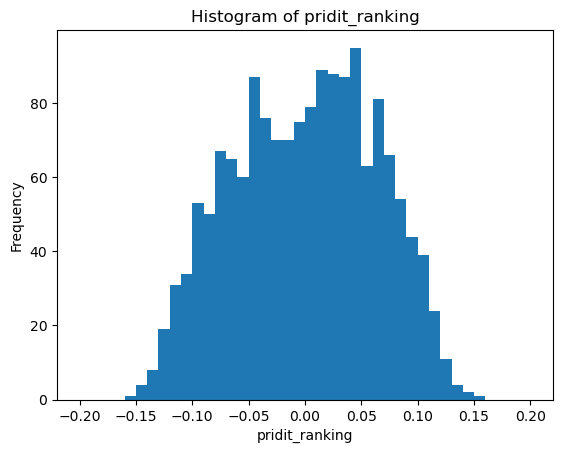

In [39]:
plt.hist(pridit_score['pridit_ranking'], bins=40, range=[-0.2, 0.2])
plt.title(f'Histogram of pridit_ranking')
plt.xlabel('pridit_ranking')
plt.ylabel('Frequency')
plt.show()

In [40]:
pridit_score

,Ticker,GP/CS,NI/TA,OP/GP,RE/TA,CFO/SAL,NI/CFO,CASH/CL,BV/TL,RSST,SOFTASSETS,ISSUE,pridit_ranking
0,A32,-0.12265,0.08623,0.52955,0.12661,0.00587,9.83866,0.18026,0.98431,0.10974,0.66435,0,-0.03551
1,AAA,-0.11680,0.03304,0.45580,0.06637,0.08246,0.46229,0.25544,0.88527,-0.05532,0.62553,0,-0.02183
2,AAM,-0.00122,-0.05677,-66.76214,-0.00949,-0.20111,0.49225,1.69371,11.61010,-0.01297,0.83726,0,0.04502
3,AAS,-0.02272,0.00510,1.29493,0.04904,0.09747,0.06773,0.85990,1.13682,-0.50930,0.60742,0,-0.01480
4,AAT,-0.14381,0.02421,0.66023,0.13189,0.00355,13.77394,0.21399,2.74274,-0.22272,0.46514,0,-0.05670
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-0.30478,0.00021,-0.26169,-0.16045,-0.55411,-0.00155,1.50844,21.60266,0.05843,0.76099,0,0.03136
1593,YBC,-0.07752,0.00209,0.62240,-0.03946,-0.02259,-0.09507,0.01160,0.16012,-0.00718,0.53618,0,0.08311
1594,YBM,-0.44716,0.03168,0.29555,0.06825,0.07707,0.40495,0.09085,0.69408,-0.03809,0.50196,0,-0.02194
1595,YEG,-0.03058,-0.12997,-6.53992,-0.15833,-0.35120,0.42058,0.08441,1.74438,-0.02006,0.96994,0,0.09345


# Evaluation

In [41]:
df_with_score.iloc[:, :4]

,Ticker,mscore,fscore,zscore
0,A32,-2.79397,0.49848,6.76237
1,AAA,-3.86643,0.37259,5.22722
2,AAM,-3.63254,0.88322,19.75009
3,AAS,1.69346,0.32348,8.05510
4,AAT,-3.62432,0.19660,7.74551
...,...,...,...,...
1592,XPH,-2.79161,0.49522,27.57365
1593,YBC,-3.15123,0.31644,1.40760
1594,YBM,-3.37026,0.26232,4.99280
1595,YEG,-1.87321,15.31524,5.98909


In [42]:
pridit_score = pd.merge(df_with_score.iloc[:, :4], pridit_score, on='Ticker', how='inner')
pridit_score

,Ticker,mscore,fscore,zscore,GP/CS,NI/TA,OP/GP,RE/TA,CFO/SAL,NI/CFO,CASH/CL,BV/TL,RSST,SOFTASSETS,ISSUE,pridit_ranking
0,A32,-2.79397,0.49848,6.76237,-0.12265,0.08623,0.52955,0.12661,0.00587,9.83866,0.18026,0.98431,0.10974,0.66435,0,-0.03551
1,AAA,-3.86643,0.37259,5.22722,-0.11680,0.03304,0.45580,0.06637,0.08246,0.46229,0.25544,0.88527,-0.05532,0.62553,0,-0.02183
2,AAM,-3.63254,0.88322,19.75009,-0.00122,-0.05677,-66.76214,-0.00949,-0.20111,0.49225,1.69371,11.61010,-0.01297,0.83726,0,0.04502
3,AAS,1.69346,0.32348,8.05510,-0.02272,0.00510,1.29493,0.04904,0.09747,0.06773,0.85990,1.13682,-0.50930,0.60742,0,-0.01480
4,AAT,-3.62432,0.19660,7.74551,-0.14381,0.02421,0.66023,0.13189,0.00355,13.77394,0.21399,2.74274,-0.22272,0.46514,0,-0.05670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,-2.79161,0.49522,27.57365,-0.30478,0.00021,-0.26169,-0.16045,-0.55411,-0.00155,1.50844,21.60266,0.05843,0.76099,0,0.03136
1593,YBC,-3.15123,0.31644,1.40760,-0.07752,0.00209,0.62240,-0.03946,-0.02259,-0.09507,0.01160,0.16012,-0.00718,0.53618,0,0.08311
1594,YBM,-3.37026,0.26232,4.99280,-0.44716,0.03168,0.29555,0.06825,0.07707,0.40495,0.09085,0.69408,-0.03809,0.50196,0,-0.02194
1595,YEG,-1.87321,15.31524,5.98909,-0.03058,-0.12997,-6.53992,-0.15833,-0.35120,0.42058,0.08441,1.74438,-0.02006,0.96994,0,0.09345


In [43]:
def check_overlapping(pridit_score, score_name, threshold,ver='none'):
    flagged_pridit_score = pridit_score.sort_values(by='pridit_ranking',ascending = False)[:threshold]
    
    if score_name == 'mscore':
        overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > -1.78]
    elif score_name == 'fscore':
        if ver == 'high':
            overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > 1.85]
        if ver == 'moderate':
            overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > 1]
    elif score_name == 'zscore':
        overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] < 1.1]
    
    print("Number of overlapping firms", len(overlap_score))
    print("Percentage of overlapping firms", len(overlap_score)/ len(flagged_pridit_score))
    return overlap_score

In [44]:
overlap_mscore_1 = check_overlapping(pridit_score, 'mscore', 30)

Number of overlapping firms 6
Percentage of overlapping firms 0.2


In [45]:
overlap_fscore_1 = check_overlapping(pridit_score, 'fscore', 30, 'high')

Number of overlapping firms 4
Percentage of overlapping firms 0.13333333333333333


In [46]:
overlap_fscore_2 = check_overlapping(pridit_score, 'fscore', 30, 'moderate')

Number of overlapping firms 8
Percentage of overlapping firms 0.26666666666666666


In [47]:
overlap_zscore_1 = check_overlapping(pridit_score,'zscore', 30)

Number of overlapping firms 15
Percentage of overlapping firms 0.5


In [48]:
flagged_pridit_score = pridit_score.sort_values(by='pridit_ranking',ascending = False)

In [49]:
# from openpyxl import load_workbook

# def append_df_to_excel(filename, df, sheet_name):
#     with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer:
#         writer.book = load_workbook(filename)
#         df.to_excel(writer, sheet_name=sheet_name, index=False)

# append_df_to_excel('./data/flagged_list.xlsx', flagged_pridit_score, 'pridit_longlist')
# append_df_to_excel('./data/score_raw.xlsx', pridit_score, 'pridit_longlist')